<a id="seccion-1"></a>

<h1 style="text-align: center; font-size: 70px; font-weight: 500;">Análisis de Indicadores: Sistema ETC Automatizado</h1>

- Autor: José Guillermo Sepúlveda Salazar.
- Practicante, Unidad de Estadística, UFRO, 2024.

<a id="seccion-2"></a>

## **Descripción**
Este documento detalla un enfoque metodológico sistemático destinado a la automatización de indicadores, que se extiende desde la adquisición de datos en línea hasta su cálculo y almacenamiento subsiguiente en Sistemas de Gestión de Bases de Datos (SGBD). Se ha implementado un marco metodológico que incluye una estructura de validación robusta para la extracción de archivos, garantizando su correcta integración en el repositorio designado. Además, realiza una verificación dentro del SGBD para asegurar la actualización de los indicadores correspondientes al año 2021.

Con el objetivo de reforzar la seguridad y asegurar la confidencialidad de los datos, el sistema incorpora mecanismos de autenticación avanzados. Esta estrategia no solo optimiza la eficiencia en la gestión de indicadores, sino que también protege la integridad de la información confidencial, cumpliendo así con los estándares de seguridad necesarios para el manejo de datos sensibles.

El proceso de automatización se estructura en tres fases fundamentales: extracción, transformación y carga (ETC). Durante la fase de extracción, el sistema verifica la presencia de la base de datos en el repositorio. En caso de no encontrarse, se procede a realizar una extracción de datos mediante técnicas de Web Scraping o conexiones API, lo que incluye la descarga y asignación de nombres a los archivos correspondientes. En la etapa de transformación, se llevan a cabo análisis estadísticos sobre cada indicador susceptible de actualización, lo que permite obtener resultados renovados. Finalmente, en la etapa de carga, el sistema se conecta al SGBD mediante credenciales de acceso específicas y verifica la actualización de los indicadores mediante la búsqueda del año correspondiente. Si los indicadores no están actualizados, se procede a la carga de los datos previamente transformados.

<a id="indice"></a>

## **Índice**
- [Portada](#seccion-1)
- [Descripción](#seccion-2)
- [Indicadores no aplicables](#seccion-3)
- [I) Extracción](#seccion-4)
    - [Obtenemos la BD de estudiantes matriculados en educación superior historica 2007-2023 de miFuturo.](#subseccion-4-1)
    - [Obtenemos la BD del personal académico del sistema de educación superior año 2022 de miFuturo.](#subseccion-4-2)
    
- [II) Transformación](#seccion-5)
    - [2. Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](#subseccion-5-2)
        - [Grafica del indicador 2](#subseccion-5-2-1)
    - [5. Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](#subseccion-5-5)
        - [Grafica del indicador 5](#subseccion-5-5-1)
    - [6. Distribución de matrículas de pregrado, magíster y doctorado según sexo.](#subseccion-5-6)
        - [Grafica del indicador 6](#subseccion-5-6-1)
    - [7. Distribución de personas matriculadas en pregrado según sexo por campo de educación.](#subseccion-5-7)
        - [Grafica del indicador 7](#subseccion-5-7-1)
    - [8. Distribución del personal académico de las instituciones de educación superior según sexo.](#subseccion-5-8)

- [III) Carga](#seccion-6)
    - [2. Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](#subseccion-6-2)
    - [5. Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](#subseccion-6-5)
    - [6. Distribución de matrículas de pregrado, magíster y doctorado según sexo.](#subseccion-6-6)
    - [7. Distribución de personas matriculadas en pregrado según sexo por campo de educación.](#subseccion-6-7)
    - [8. Distribución del personal académico de las instituciones de educación superior según sexo.](#subseccion-6-8)

<a id="seccion-3"></a>

## **Indicadores no aplicables**

- 1. **[Cantidad de programas de magíster y doctorado ofrecidos por universidades según región de sede (excluyendo la Región Metropolitana)](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/numero-de-programas-de-magister-y-doctorado-por-region)**

- 3. **[Evolución anual de la cantidad de programas de postgrado ofrecidos por universidades en Chile, según región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-programas-de-postgrado-por-region)**

- 4. **[Cantidad de programas de postgrado en áreas STEM por región de sede.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/porcentaje_matricula_regional_stem)**

[Volver al índice](#indice) 

<a id="seccion-4"></a>

# **I) Extracción**

[Volver al índice](#indice)

In [1]:
# Importamos las librerias necesarias
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import matplotlib.pyplot as plt
import openpyxl
import time
import os
import pandas as pd
import numpy as np
import zipfile

<a id="subseccion-4-1"></a>

## [Obtenemos la BD de estudiantes matriculados en educación superior historica 2007-2023 de miFuturo.](https://www.mifuturo.cl/bases-de-datos-de-matriculados/)

[Volver al índice](#indice)

In [2]:
def esperar_descarga_completa(directorio, extension, timeout=300):
    tiempo_inicio = time.time()
    while True:
        archivos_temporales = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.crdownload') or archivo.endswith('.part')]
        if not archivos_temporales:
            # Espera un momento después de que desaparezcan los archivos temporales para asegurar que la descarga ha finalizado
            time.sleep(1)
            archivos = [archivo for archivo in os.listdir(directorio) if archivo.endswith(extension)]
            if archivos:
                return os.path.join(directorio, archivos[-1])  # Retorna el último archivo descargado con la extensión deseada
        elif (time.time() - tiempo_inicio) > timeout:
            raise Exception("Tiempo de espera para la finalización de la descarga excedido.")
        time.sleep(1)

# Función para obtener el último archivo descargado
def obtener_ultimo_archivo_descargado(directorio):
    lista_de_archivos = os.listdir(directorio)
    rutas_completas = [os.path.join(directorio, archivo) for archivo in lista_de_archivos]
    archivo_mas_reciente = max(rutas_completas, key=os.path.getmtime)
    return archivo_mas_reciente

nombre_del_archivo = "MATRICULA_SIES_ 2007_AL_2023.csv"     # Nombre del archivo a buscar
carpeta = os.getcwd()                                       # Utiliza el directorio actual de trabajo como carpeta de búsqueda
ruta_completa = os.path.join(carpeta, nombre_del_archivo)   # Construcción de la ruta del archivo

# Verificar si el archivo existe en la carpeta
if os.path.isfile(ruta_completa):
    print(f"El archivo '{nombre_del_archivo}' está presente en el directorio actual.")
else:
    print(f"El archivo '{nombre_del_archivo}' no se encontró en el directorio actual.")
    print("Procedemos al Scraping para obtener el descargable.")
    # Configurar opciones de Selenium y Chrome
    options = webdriver.ChromeOptions()

    # Especificar la carpeta de descarga como el directorio actual de trabajo
    current_directory = os.getcwd()
    prefs = {"download.default_directory": current_directory}
    options.add_experimental_option("prefs", prefs)

    # Inicializar el WebDriver
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    # Acceder a la página web
    url = "https://www.mifuturo.cl/bases-de-datos-de-matriculados/"
    driver.get(url)

    WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.TAG_NAME, "body")))       # Carga la página
    time.sleep(1)
    Click = WebDriverWait(driver, 0).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "body > div > div > div:nth-child(7) > div.col-md-8.text-justify.col-content > div:nth-child(4) > div > p:nth-child(3) > a"))).click()
    time.sleep(1)
    # Esperar a que la descarga se complete
    ruta_archivo_descargado = esperar_descarga_completa(carpeta, '.zip')
    driver.quit()                                                                               # Cierra el navegador

    ultimo_archivo_descargado = obtener_ultimo_archivo_descargado(current_directory)            # Obtener el último archivo descargado
    print("Zip Descargado")
    # Extraer el contenido del archivo zip y renombrar el CSV
    with zipfile.ZipFile(ultimo_archivo_descargado, 'r') as archivo_zip:
        for miembro_zip in archivo_zip.namelist():
            if miembro_zip.endswith('.csv'):
                archivo_zip.extract(miembro_zip, carpeta)
                print("archivo descomprimido")
                # Renombrar el archivo CSV
                os.rename(os.path.join(carpeta, miembro_zip), os.path.join(carpeta, nombre_del_archivo))
                print(f"El archivo '{miembro_zip}' ha sido renombrado a '{nombre_del_archivo}'.")
                break 

    # Eliminar el archivo zip después de la extracción
    os.remove(ultimo_archivo_descargado)    
    print("carpeta zip eliminada")
   
    print("Descarga, extracción y renombrado completado")

El archivo 'MATRICULA_SIES_ 2007_AL_2023.csv' está presente en el directorio actual.


<a id="subseccion-4-2"></a>

## [Obtenemos la BD del personal académico del sistema de educación superior año 2022 de miFuturo.](https://www.mifuturo.cl/bases-de-datos-personal-academico/)

[Volver al índice](#indice)

In [3]:
def esperar_descarga_completa(directorio, extension, timeout=300):
    tiempo_inicio = time.time()
    while True:
        archivos_temporales = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.crdownload') or archivo.endswith('.part')]
        if not archivos_temporales:
            # Espera un momento después de que desaparezcan los archivos temporales para asegurar que la descarga ha finalizado
            time.sleep(1)
            archivos = [archivo for archivo in os.listdir(directorio) if archivo.endswith(extension)]
            if archivos:
                return os.path.join(directorio, archivos[-1])  # Retorna el último archivo descargado con la extensión deseada
        elif (time.time() - tiempo_inicio) > timeout:
            raise Exception("Tiempo de espera para la finalización de la descarga excedido.")
        time.sleep(1)

# Función para obtener el último archivo descargado
def obtener_ultimo_archivo_descargado(directorio):
    lista_de_archivos = os.listdir(directorio)
    rutas_completas = [os.path.join(directorio, archivo) for archivo in lista_de_archivos]
    archivo_mas_reciente = max(rutas_completas, key=os.path.getmtime)
    return archivo_mas_reciente

nombre_del_archivo = "Personal_Academico_SIES_2022.xlsx"    # Nombre del archivo a buscar
carpeta = os.getcwd()                                       # Utiliza el directorio actual de trabajo como carpeta de búsqueda
ruta_completa = os.path.join(carpeta, nombre_del_archivo)   # Construcción de la ruta del archivo

# Verificar si el archivo existe en la carpeta
if os.path.isfile(ruta_completa):
    print(f"El archivo '{nombre_del_archivo}' está presente en el directorio actual.")
else:
    print(f"El archivo '{nombre_del_archivo}' no se encontró en el directorio actual.")
    print("Procedemos al Scraping para obtener el descargable.")
    # Configurar opciones de Selenium y Chrome
    options = webdriver.ChromeOptions()

    # Especificar la carpeta de descarga como el directorio actual de trabajo
    current_directory = os.getcwd()
    prefs = {"download.default_directory": current_directory}
    options.add_experimental_option("prefs", prefs)

    # Inicializar el WebDriver
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    # Acceder a la página web
    url = "https://www.mifuturo.cl/bases-de-datos-personal-academico/"
    driver.get(url)

    WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.TAG_NAME, "body")))       # Carga la página
    time.sleep(1)
    Click = WebDriverWait(driver, 0).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "body > div > div > div:nth-child(7) > div.col-md-8.text-justify.col-content > div:nth-child(4) > div > p:nth-child(3) > a"))).click()
    time.sleep(1)
    # Esperar a que la descarga se complete
    ruta_archivo_descargado = esperar_descarga_completa(carpeta, '.xlsx')
    driver.quit()                                                                               # Cierra el navegador
    ultimo_archivo_descargado = obtener_ultimo_archivo_descargado(current_directory)            # Obtener el último archivo descargado
    os.rename(ultimo_archivo_descargado, os.path.join(current_directory, nombre_del_archivo))   # Renombrar el último archivo descargado
    
    print("Descarga y renombrado completo.")

El archivo 'Personal_Academico_SIES_2022.xlsx' está presente en el directorio actual.


<a id="seccion-5"></a>

# **II) Transformación**

[Volver al índice](#indice) 

<a id="subseccion-5-2"></a>

## 2. **[Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-matricula-pregrado-magister-y-doctorado-en-universidades-en-chile)**

 * **Archivo**: MATRICULA_SIES_ 2007_AL_2023.csv
 * **Descripción**: En esta sección, se realiza la carga de un archivo CSV para convertirlo en un DataFrame. Posteriormente, se aplica un filtro para el año 2022. Mediante el uso de NumPy, se añade una columna adicional llamada "AUX_NIVEL" al DataFrame. Esta nueva columna se categoriza en base a los valores de "CARRERA CLASIFICACIÓN NIVEL 2". Finalmente, se exhiben los resultados obtenidos a través de la consola. Cabe destacar que la columna correspondiente al año se excluye en esta fase ya que en la carga de los datos se utiliza ese argumento.

[Volver al índice](#indice)    

In [4]:
# Leer el archivo CSV en un DataFrame de pandas
df_matricula = pd.read_csv("MATRICULA_SIES_ 2007_AL_2023.csv", encoding='ISO-8859-1', sep=';', low_memory=False) 

# Filtra los datos para el año 2022
df_filtrado = df_matricula[(df_matricula['AÑO'] == 'MAT_2022')]

# Define las columnas relevantes según los parámetros proporcionados sin el parámetro año
columnas_relevantes = [
    'TOTAL MATRICULADOS', 'MATRICULADOS MUJERES POR PROGRAMA',
    'MATRICULADOS HOMBRES POR PROGRAMA', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1',
    'CLASIFICACIÓN INSTITUCIÓN NIVEL 2', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 3',
    'REGIÓN', 'NOMBRE CARRERA', 'ÁREA DEL CONOCIMIENTO', 'CINE-F 1997 ÁREA',
    'CINE-F 1997 SUBAREA', 'ÁREA CARRERA GENÉRICA', 'CINE-F 2013 ÁREA',
    'CINE-F 2013 SUBAREA', 'NIVEL GLOBAL', 'CARRERA CLASIFICACIÓN NIVEL 1',
    'CARRERA CLASIFICACIÓN NIVEL 2'
]

# Asegurarse de que df_matricula es una copia independiente
df_matricula = df_filtrado[columnas_relevantes].copy()

# Definir las condiciones
condiciones = [
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'].isin(['Carreras Profesionales', 'Carreras Técnicas']),
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Magister',
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Doctorado',
    df_matricula['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Postítulo'
]

# Definir las elecciones correspondientes a cada condición
elecciones = [
    'Pregrado',
    'Magister',
    'Doctorado',
    'No aplica'
]

# Crear la nueva columna 'AUX_NIVEL' con np.select
df_matricula['AUX_NIVEL'] = np.select(condiciones, elecciones, default='Otro')

# Mostrar el DataFrame modificado
print(df_matricula)

       TOTAL MATRICULADOS  MATRICULADOS MUJERES POR PROGRAMA  \
16051                  39                               17.0   
16052                 169                              114.0   
16053                  79                               63.0   
16054                 313                              252.0   
16055                   1                                1.0   
...                   ...                                ...   
31677                  25                               19.0   
31678                  39                               26.0   
31679                   8                                2.0   
31680                  12                                3.0   
31681                  13                                6.0   

       MATRICULADOS HOMBRES POR PROGRAMA CLASIFICACIÓN INSTITUCIÓN NIVEL 1  \
16051                               22.0                     Universidades   
16052                               55.0                     Universidades 

<a id="subseccion-5-2-1"></a>

- ### **Grafica del indicador 2 :** [Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-matricula-pregrado-magister-y-doctorado-en-universidades-en-chile)


[Volver al índice](#indice)    

In [5]:
def calculo_distribucion(df):
    # Gráfico Evolución de matrículas anuales en pregrado y postgrado en universidades en chile
    matricula_pregrado  = df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['NIVEL GLOBAL'] == 'Pregrado')]['TOTAL MATRICULADOS'].sum()
    matricula_postgrado = df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['NIVEL GLOBAL'] == 'Postgrado')]['TOTAL MATRICULADOS'].sum()

    # Cantidad de matrículas anuales de magíster y doctorado en la universidades en Chile.
    matricula_Dr        = df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['AUX_NIVEL'] == 'Doctorado')]['TOTAL MATRICULADOS'].sum()
    matricula_Mg        = df[(df['CLASIFICACIÓN INSTITUCIÓN NIVEL 1'] == 'Universidades') & (df['AUX_NIVEL'] == 'Magister')]['TOTAL MATRICULADOS'].sum()

    return matricula_pregrado, matricula_postgrado, matricula_Dr, matricula_Mg

# Llamar a la función y almacenar 
matricula_pregrado, matricula_postgrado, matricula_Dr, matricula_Mg = calculo_distribucion(df_matricula)

# Mostrar los resultados
print('Matriculas en pregrado en universidades en chile:    {:.0f} Personas'.format(matricula_pregrado))
print('Matriculas en postgrado en universidades en chile:   {:.0f} Personas\n'.format(matricula_postgrado))
print('Matriculas en doctorado en universidades en chile:   {:.0f} Personas'.format(matricula_Dr))
print('Matriculas en magístes en universidades en chile:    {:.0f} Personas'.format(matricula_Mg))

Matriculas en pregrado en universidades en chile:    683217 Personas
Matriculas en postgrado en universidades en chile:   54579 Personas

Matriculas en doctorado en universidades en chile:   6875 Personas
Matriculas en magístes en universidades en chile:    47704 Personas


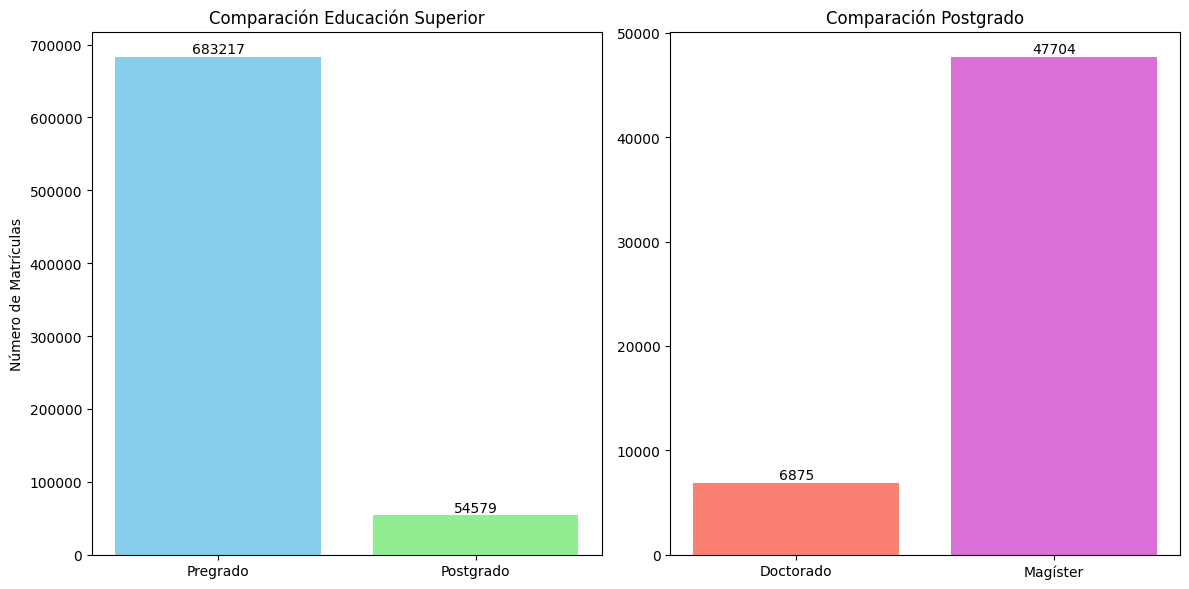

In [6]:
# Datos obtenidos de la función
matriculas_pre_post = [matricula_pregrado, matricula_postgrado]
nombres_pre_post = ['Pregrado', 'Postgrado']

matriculas_dr_mg = [matricula_Dr, matricula_Mg]
nombres_dr_mg = ['Doctorado', 'Magíster']

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Subgráfico para Pregrado vs Postgrado
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
plt.bar(nombres_pre_post, matriculas_pre_post, color=['skyblue', 'lightgreen'])
plt.title('Comparación Educación Superior')
plt.ylabel('Número de Matrículas')

# Añadir valores sobre las barras
for i, v in enumerate(matriculas_pre_post):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')

# Subgráfico para Doctorado vs Magíster
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
plt.bar(nombres_dr_mg, matriculas_dr_mg, color=['salmon', 'orchid'])
plt.title('Comparación Postgrado')

# Añadir valores sobre las barras
for i, v in enumerate(matriculas_dr_mg):
    plt.text(i, v + 100, str(v), ha='center', va='bottom')

# Ajustar layout para evitar superposición
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [7]:
# Obtener los primeros 5 resultados de df_matricula
primeros_cinco_resultados_matricula = df_matricula.head()

# Mostrar los primeros 5 resultados
print(primeros_cinco_resultados_matricula)

       TOTAL MATRICULADOS  MATRICULADOS MUJERES POR PROGRAMA  \
16051                  39                               17.0   
16052                 169                              114.0   
16053                  79                               63.0   
16054                 313                              252.0   
16055                   1                                1.0   

       MATRICULADOS HOMBRES POR PROGRAMA CLASIFICACIÓN INSTITUCIÓN NIVEL 1  \
16051                               22.0                     Universidades   
16052                               55.0                     Universidades   
16053                               16.0                     Universidades   
16054                               61.0                     Universidades   
16055                                NaN                     Universidades   

      CLASIFICACIÓN INSTITUCIÓN NIVEL 2 CLASIFICACIÓN INSTITUCIÓN NIVEL 3  \
16051            Universidades Privadas            Universidades Priv

<a id="subseccion-5-5"></a>

## 5. **[Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-la-educacion-superior-respecto-al-total)**

<a id="subseccion-5-6"></a>

## 6. **[Distribución de matrículas de pregrado, magíster y doctorado según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado)**

<a id="subseccion-5-7"></a>

## 7. **[Distribución de personas matriculadas en pregrado según sexo por campo de educación.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado-por-area-de-conocimiento)**

* **Archivo**: MATRICULA_SIES_ 2007_AL_2023.csv
* **Descripción**: En esta sección, se realiza la carga de un archivo CSV para convertirlo en un DataFrame. Posteriormente, se aplica un filtro para el año 2022. Mediante el uso de NumPy, se añade una columna adicional llamada "AUX_NIVEL" al DataFrame. Esta nueva columna se categoriza en base a los valores de "CARRERA CLASIFICACIÓN NIVEL 2". Para lograr una representación detallada de los datos de matriculación, el script duplica cada fila del DataFrame resultante para separar los datos de hombres y mujeres, asignando a cada uno la cantidad correspondiente de matriculados y ajustando la categorización de sexo. Las columnas originales de matriculados por género se eliminan después de este paso para evitar redundancias. El script finaliza combinando los DataFrames de hombres y mujeres en uno solo y eliminando cualquier fila que contenga valores nulos en la columna "Matriculados", mostrando los datos procesados por consola.  Cabe destacar que la columna correspondiente al año se excluye en esta fase ya que en la carga de los datos se utiliza ese argumento.

[Volver al índice](#indice) 

In [8]:
# Leer el archivo CSV en un DataFrame de pandas
df_matricula = pd.read_csv("MATRICULA_SIES_ 2007_AL_2023.csv", encoding='ISO-8859-1', sep=';', low_memory=False) 

# Filtra los datos para el año 2022, excluyendo los postítulos
df_filtrado = df_matricula[(df_matricula['AÑO'] == 'MAT_2022') & (df_matricula['NIVEL GLOBAL'].isin(['Pregrado', 'Postgrado']))]

# Define las columnas relevantes según los parámetros proporcionados sin el parámetro año
columnas_relevantes = [
    'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA',
    'CINE-F 2013 ÁREA', 'CARRERA CLASIFICACIÓN NIVEL 2'
]

# Asegurarse de que df_modificacion_1 es una copia independiente
df_modificacion_1 = df_filtrado[columnas_relevantes].copy()

# Definir las condiciones
condiciones = [
    df_modificacion_1['CARRERA CLASIFICACIÓN NIVEL 2'].isin(['Carreras Profesionales', 'Carreras Técnicas']),
    df_modificacion_1['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Magister',
    df_modificacion_1['CARRERA CLASIFICACIÓN NIVEL 2'] == 'Doctorado'
]

# Definir las elecciones correspondientes a cada condición
elecciones = [
    'Pregrado',
    'Magister',
    'Doctorado'
]

# Crear la nueva columna 
df_modificacion_1['NIVEL'] = np.select(condiciones, elecciones)

# Duplicar cada fila del DataFrame, una para Hombres y otra para Mujeres
df_hombres = df_modificacion_1.copy()
df_mujeres = df_modificacion_1.copy()

# Asignar la categoría correspondiente a la nueva columna 'Sexo'
df_hombres['Sexo'] = 'Hombres'
df_mujeres['Sexo'] = 'Mujeres'

# Asignar a cada fila la cantidad de matriculados de cada sexo 
df_hombres['Matriculados'] = df_hombres['MATRICULADOS HOMBRES POR PROGRAMA']
df_mujeres['Matriculados'] = df_mujeres['MATRICULADOS MUJERES POR PROGRAMA']

# Eliminar las columnas de matriculados por sexo, ya que no son necesarias después de asignar la 'Cantidad'
df_hombres.drop(['CARRERA CLASIFICACIÓN NIVEL 2', 'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA'], axis=1, inplace=True)
df_mujeres.drop(['CARRERA CLASIFICACIÓN NIVEL 2', 'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA'], axis=1, inplace=True)

# Combinar los DataFrames de hombres y mujeres
df_modificacion_2 = pd.concat([df_hombres, df_mujeres], ignore_index=True)

# Eliminar filas donde la columna "Matriculados" tenga valores nulos
df_matricula_agregada = df_modificacion_2.dropna(subset=['Matriculados'])

# Mostrar el DataFrame resultante
print(df_matricula_agregada)

                                     CINE-F 2013 ÁREA     NIVEL     Sexo  \
0                                 Artes y Humanidades  Pregrado  Hombres   
1         Ciencias Sociales, Periodismo e Información  Pregrado  Hombres   
2         Ciencias Sociales, Periodismo e Información  Pregrado  Hombres   
3         Ciencias Sociales, Periodismo e Información  Pregrado  Hombres   
5                                           Educación  Pregrado  Hombres   
...                                               ...       ...      ...   
27659  Agricultura, Silvicultura, Pesca y Veterinaria  Pregrado  Mujeres   
27660  Agricultura, Silvicultura, Pesca y Veterinaria  Pregrado  Mujeres   
27661  Agricultura, Silvicultura, Pesca y Veterinaria  Pregrado  Mujeres   
27662            Ingeniería, Industria y Construcción  Pregrado  Mujeres   
27663            Administración de Empresas y Derecho  Pregrado  Mujeres   

       Matriculados  
0              22.0  
1              55.0  
2              16.0  

In [9]:
'''
# Especifica el nombre del archivo que deseas crear
nombre_archivo_excel = 'resultados_sises_2022.xlsx'

# Guardar el DataFrame en un archivo Excel
df_matricula_agregada.to_excel(nombre_archivo_excel, sheet_name='hoja 1', index=False)

print(f'El DataFrame ha sido guardado exitosamente en "{nombre_archivo_excel}"')
'''

'\n# Especifica el nombre del archivo que deseas crear\nnombre_archivo_excel = \'resultados_sises_2022.xlsx\'\n\n# Guardar el DataFrame en un archivo Excel\ndf_matricula_agregada.to_excel(nombre_archivo_excel, sheet_name=\'hoja 1\', index=False)\n\nprint(f\'El DataFrame ha sido guardado exitosamente en "{nombre_archivo_excel}"\')\n'

<a id="subseccion-5-5-1"></a>

- ### **Grafica del indicador del 5 :** [Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-la-educacion-superior-respecto-al-total)

[Volver al índice](#indice) 

In [10]:
def calculo_distribucion(df):
    matriculados_mujeres = df[(df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matriculados_hombres = df[(df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    total_general        = df['Matriculados'].sum()

    return  matriculados_mujeres, matriculados_hombres, total_general

# Llamar a la función y almacenar 
matriculados_mujeres, matriculados_hombres, total_general = calculo_distribucion(df_matricula_agregada)

#calculo porcentual 
por_matriculados_mujeres = (matriculados_mujeres / total_general) * 100
por_matriculados_hombres = (matriculados_hombres / total_general) * 100

# Mostrar los resultados
print('Mujeres en Educación Superior:  {:.2f}%'.format(por_matriculados_mujeres), ' Cantidad:  {:.0f} matriculados'.format(matriculados_mujeres))
print('Hombres en Educación Superior:  {:.2f}%'.format(por_matriculados_hombres), ' Cantidad:  {:.0f} matriculados'.format(matriculados_hombres))

Mujeres en Educación Superior:  53.55%  Cantidad:  678105 matriculados
Hombres en Educación Superior:  46.45%  Cantidad:  588253 matriculados


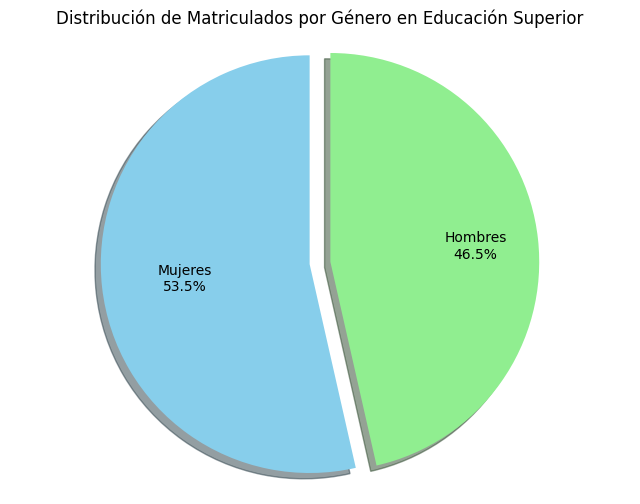

In [11]:
# Datos
etiquetas = ['Mujeres', 'Hombres']
tamaños = [matriculados_mujeres, matriculados_hombres]  # Asegúrate de definir estas variables con los datos correspondientes
colores = ['skyblue', 'lightgreen']
explode = (0.1, 0)  # resaltar la porción de mujeres

# Crear el gráfico de torta
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(tamaños, explode=explode, colors=colores, shadow=True, startangle=90)

# Añadir un título
plt.title('Distribución de Matriculados por Género en Educación Superior')

# Asegurar que la torta sea circular
plt.axis('equal')

# Función para calcular el porcentaje
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%'.format(pct)
    return my_format

# Colocar las etiquetas con los nombres y porcentajes en las porciones
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
    x = wedge.r * 0.7 * np.cos(np.deg2rad(angle))
    y = wedge.r * 0.7 * np.sin(np.deg2rad(angle))
    text = f"{etiquetas[i]}\n{autopct_format(tamaños)(tamaños[i]/sum(tamaños)*100)}"
    ax.annotate(text, xy=(x, y), ha='center', va='center')

# Mostrar el gráfico
plt.show()

<a id="subseccion-5-6-1"></a>

- ### **Grafica del indicador 6:** [Distribución de matrículas de pregrado, magíster y doctorado según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado)

[Volver al índice](#indice) 

In [12]:
def calculo_distribucion(df):
    # Gráfico Distribución de matrículas de pregrado, magíster y doctorado según sexo
    matricula_Dr_mujeres        = df[(df['NIVEL'] == 'Doctorado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_Dr_hombres        = df[(df['NIVEL'] == 'Doctorado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_Dr_total          = df[(df['NIVEL'] == 'Doctorado')]['Matriculados'].sum()

    matricula_Mg_mujeres        = df[(df['NIVEL'] == 'Magister') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_Mg_hombres        = df[(df['NIVEL'] == 'Magister') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_Mg_total          = df[(df['NIVEL'] == 'Magister')]['Matriculados'].sum()

    matricula_pregrado_mujeres  = df[(df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_pregrado_hombres  = df[(df['NIVEL'] == 'Pregrado') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_pregrado_total    = df[(df['NIVEL'] == 'Pregrado')]['Matriculados'].sum()

    return  matricula_Dr_mujeres, matricula_Dr_hombres, matricula_Dr_total, \
            matricula_Mg_mujeres, matricula_Mg_hombres, matricula_Mg_total, \
            matricula_pregrado_mujeres, matricula_pregrado_hombres, matricula_pregrado_total

# Llamar a la función y almacenar 
matricula_Dr_mujeres, matricula_Dr_hombres, matricula_Dr_total, \
matricula_Mg_mujeres, matricula_Mg_hombres, matricula_Mg_total, \
matricula_pregrado_mujeres, matricula_pregrado_hombres, matricula_pregrado_total = calculo_distribucion(df_matricula_agregada)

#calculo porcentual 
por_matricula_Dr_mujeres        = (matricula_Dr_mujeres / matricula_Dr_total) * 100
por_matricula_Dr_hombres        = (matricula_Dr_hombres / matricula_Dr_total) * 100

por_matricula_Mg_mujeres        = (matricula_Mg_mujeres / matricula_Mg_total) * 100
por_matricula_Mg_hombres        = (matricula_Mg_hombres / matricula_Mg_total) * 100

por_matricula_pregrado_mujeres  = (matricula_pregrado_mujeres / matricula_pregrado_total) * 100
por_matricula_pregrado_hombres  = (matricula_pregrado_hombres / matricula_pregrado_total) * 100

# Mostrar los resultados
print('Gráfico Distribución de matrículas de pregrado, magíster y doctorado según sexo.')
print('Matrículas de Mujeres en Doctorado: {:.2f}%'.format(por_matricula_Dr_mujeres), ' Cantidad:   {:.0f} personas'.format(matricula_Dr_mujeres))
print('Matrículas de Hombres en Doctorado: {:.2f}%'.format(por_matricula_Dr_hombres), ' Cantidad:   {:.0f} personas'.format(matricula_Dr_hombres))

print('Matrículas de Mujeres en Magister:  {:.2f}%'.format(por_matricula_Mg_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_Mg_mujeres))
print('Matrículas de Hombres en Magister:  {:.2f}%'.format(por_matricula_Mg_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_Mg_hombres))

print('Matrículas de Mujeres en Pregrado:  {:.2f}%'.format(por_matricula_pregrado_mujeres), ' Cantidad: {:.0f} personas'.format(matricula_pregrado_mujeres))
print('Matrículas de Hombres en Pregrado:  {:.2f}%'.format(por_matricula_pregrado_hombres), ' Cantidad: {:.0f} personas\n'.format(matricula_pregrado_hombres))

Gráfico Distribución de matrículas de pregrado, magíster y doctorado según sexo.
Matrículas de Mujeres en Doctorado: 42.68%  Cantidad:   2934 personas
Matrículas de Hombres en Doctorado: 57.32%  Cantidad:   3941 personas
Matrículas de Mujeres en Magister:  51.03%  Cantidad:  24341 personas
Matrículas de Hombres en Magister:  48.97%  Cantidad:  23363 personas
Matrículas de Mujeres en Pregrado:  53.71%  Cantidad: 650830 personas
Matrículas de Hombres en Pregrado:  46.29%  Cantidad: 560949 personas



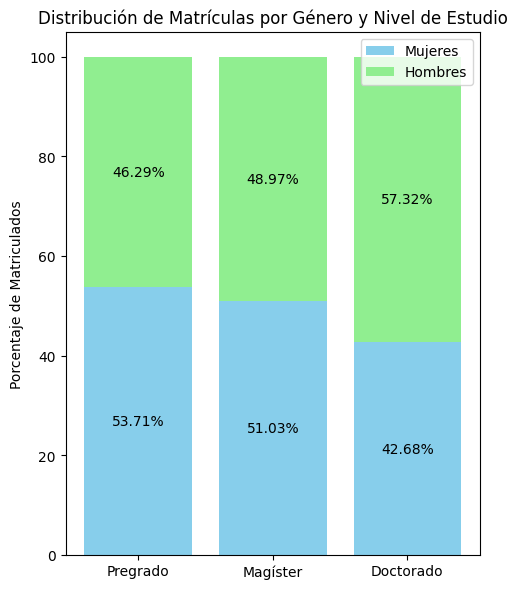

In [13]:
# Niveles de estudio
niveles_estudio = ['Pregrado', 'Magíster', 'Doctorado']

# Datos: Porcentajes de matrículas por género en cada nivel de estudio
porcentajes_mujeres = [por_matricula_pregrado_mujeres, por_matricula_Mg_mujeres, por_matricula_Dr_mujeres]
porcentajes_hombres = [por_matricula_pregrado_hombres, por_matricula_Mg_hombres, por_matricula_Dr_hombres]

x = np.arange(len(niveles_estudio))  # Ubicación de las etiquetas en el eje X

fig, ax = plt.subplots(figsize=(5, 6))

# Crear barras apiladas para mujeres
rects1 = ax.bar(x, porcentajes_mujeres, label='Mujeres', color='skyblue')

# Crear barras apiladas para hombres, comenzando donde terminan las de mujeres
rects2 = ax.bar(x, porcentajes_hombres, bottom=porcentajes_mujeres, label='Hombres', color='lightgreen')

# Añadir título y etiquetas a los ejes
ax.set_ylabel('Porcentaje de Matriculados')
ax.set_title('Distribución de Matrículas por Género y Nivel de Estudio')
ax.set_xticks(x)
ax.set_xticklabels(niveles_estudio)
ax.legend()

# Función para añadir etiquetas sobre cada barra
def autolabel(rects, labels, is_bottom):
    for rect, label in zip(rects, labels):
        if is_bottom:  # Para la sección inferior (mujeres)
            height = rect.get_height() / 2  # Colocar la etiqueta en el centro de la sección de mujeres
        else:  # Para la sección superior (hombres)
            height = rect.get_y() + rect.get_height() / 2  # Colocar la etiqueta en el centro de la sección de hombres
        ax.annotate('{:.2f}%'.format(label),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # Sin offset
                    textcoords="offset points",
                    ha='center', va='center')

# Añadir etiquetas de porcentaje a las barras de mujeres
autolabel(rects1, porcentajes_mujeres, is_bottom=True)

# Añadir etiquetas de porcentaje a las barras de hombres, utilizando solo el porcentaje de hombres
autolabel(rects2, porcentajes_hombres, is_bottom=False)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

<a id="subseccion-5-7-1"></a>

- ### **Grafica del indicador 7:** [Distribución de personas matriculadas en pregrado según sexo por campo de educación.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado-por-area-de-conocimiento)

[Volver al índice](#indice)

In [14]:
def calculo_distribucion(df):
    # Administración de Empresas y Derecho
    matricula_AD_mujeres   = df[(df['CINE-F 2013 ÁREA'] == 'Administración de Empresas y Derecho') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_AD_hombres   = df[(df['CINE-F 2013 ÁREA'] == 'Administración de Empresas y Derecho') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_AD_total     = df[(df['CINE-F 2013 ÁREA'] == 'Administración de Empresas y Derecho')]['Matriculados'].sum()
    # Agricultura, Silvicultura, Pesca y Veterinaria
    matricula_ASPV_mujeres = df[(df['CINE-F 2013 ÁREA'] == 'Agricultura, Silvicultura, Pesca y Veterinaria') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_ASPV_hombres = df[(df['CINE-F 2013 ÁREA'] == 'Agricultura, Silvicultura, Pesca y Veterinaria') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_ASPV_total   = df[(df['CINE-F 2013 ÁREA'] == 'Agricultura, Silvicultura, Pesca y Veterinaria')]['Matriculados'].sum()
    # Artes y Humanidades
    matricula_AH_mujeres   = df[(df['CINE-F 2013 ÁREA'] == 'Artes y Humanidades') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_AH_hombres   = df[(df['CINE-F 2013 ÁREA'] == 'Artes y Humanidades') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_AH_total     = df[(df['CINE-F 2013 ÁREA'] == 'Artes y Humanidades')]['Matriculados'].sum()
    # Ciencias naturales, matemáticas y estadística
    matricula_CME_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias naturales, matemáticas y estadística') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_CME_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias naturales, matemáticas y estadística') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_CME_total    = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias naturales, matemáticas y estadística')]['Matriculados'].sum()
    # Ciencias Sociales, Periodismo e Información
    matricula_CPI_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias Sociales, Periodismo e Información') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_CPI_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias Sociales, Periodismo e Información') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_CPI_total    = df[(df['CINE-F 2013 ÁREA'] == 'Ciencias Sociales, Periodismo e Información')]['Matriculados'].sum()
    # Educación
    matricula_E_mujeres    = df[(df['CINE-F 2013 ÁREA'] == 'Educación') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_E_hombres    = df[(df['CINE-F 2013 ÁREA'] == 'Educación') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_E_total      = df[(df['CINE-F 2013 ÁREA'] == 'Educación')]['Matriculados'].sum()
    # Ingeniaría, Industria y Construcción
    matricula_IIC_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Ingeniería, Industria y Construcción') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_IIC_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Ingeniería, Industria y Construcción') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_IIC_total    = df[(df['CINE-F 2013 ÁREA'] == 'Ingeniería, Industria y Construcción')]['Matriculados'].sum()
    # Salud y Bienestar
    matricula_SB_mujeres   = df[(df['CINE-F 2013 ÁREA'] == 'Salud y Bienestar') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_SB_hombres   = df[(df['CINE-F 2013 ÁREA'] == 'Salud y Bienestar') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_SB_total     = df[(df['CINE-F 2013 ÁREA'] == 'Salud y Bienestar')]['Matriculados'].sum()
    # Servicios
    matricula_S_mujeres    = df[(df['CINE-F 2013 ÁREA'] == 'Servicios') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_S_hombres    = df[(df['CINE-F 2013 ÁREA'] == 'Servicios') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_S_total      = df[(df['CINE-F 2013 ÁREA'] == 'Servicios')]['Matriculados'].sum()
    # Tecnología de la Información y la Comunicación (TIC)
    matricula_TIC_mujeres  = df[(df['CINE-F 2013 ÁREA'] == 'Tecnología de la Información y la Comunicación (TIC)') & (df['Sexo'] == 'Mujeres')]['Matriculados'].sum()
    matricula_TIC_hombres  = df[(df['CINE-F 2013 ÁREA'] == 'Tecnología de la Información y la Comunicación (TIC)') & (df['Sexo'] == 'Hombres')]['Matriculados'].sum()
    matricula_TIC_total    = df[(df['CINE-F 2013 ÁREA'] == 'Tecnología de la Información y la Comunicación (TIC)')]['Matriculados'].sum()

    return  matricula_AD_mujeres, matricula_AD_hombres, matricula_AD_total, \
            matricula_ASPV_mujeres, matricula_ASPV_hombres, matricula_ASPV_total, \
            matricula_AH_mujeres, matricula_AH_hombres, matricula_AH_total, \
            matricula_CME_mujeres, matricula_CME_hombres, matricula_CME_total, \
            matricula_CPI_mujeres, matricula_CPI_hombres, matricula_CPI_total, \
            matricula_E_mujeres, matricula_E_hombres, matricula_E_total, \
            matricula_IIC_mujeres, matricula_IIC_hombres, matricula_IIC_total, \
            matricula_SB_mujeres, matricula_SB_hombres, matricula_SB_total, \
            matricula_S_mujeres, matricula_S_hombres, matricula_S_total, \
            matricula_TIC_mujeres, matricula_TIC_hombres, matricula_TIC_total

# Llamar a la función y almacenar 
matricula_AD_mujeres, matricula_AD_hombres, matricula_AD_total, \
matricula_ASPV_mujeres, matricula_ASPV_hombres, matricula_ASPV_total, \
matricula_AH_mujeres, matricula_AH_hombres, matricula_AH_total, \
matricula_CME_mujeres, matricula_CME_hombres, matricula_CME_total, \
matricula_CPI_mujeres, matricula_CPI_hombres, matricula_CPI_total, \
matricula_E_mujeres, matricula_E_hombres, matricula_E_total, \
matricula_IIC_mujeres, matricula_IIC_hombres, matricula_IIC_total, \
matricula_SB_mujeres, matricula_SB_hombres, matricula_SB_total, \
matricula_S_mujeres, matricula_S_hombres, matricula_S_total, \
matricula_TIC_mujeres, matricula_TIC_hombres, matricula_TIC_total = calculo_distribucion(df_matricula_agregada)

#calculo porcentual 
por_matricula_AD_mujeres   = (matricula_AD_mujeres / matricula_AD_total) * 100
por_matricula_AD_hombres   = (matricula_AD_hombres / matricula_AD_total) * 100

por_matricula_ASPV_mujeres = (matricula_ASPV_mujeres / matricula_ASPV_total) * 100
por_matricula_ASPV_hombres = (matricula_ASPV_hombres / matricula_ASPV_total) * 100

por_matricula_AH_mujeres   = (matricula_AH_mujeres / matricula_AH_total) * 100
por_matricula_AH_hombres   = (matricula_AH_hombres / matricula_AH_total) * 100

por_matricula_CME_mujeres  = (matricula_CME_mujeres / matricula_CME_total) * 100
por_matricula_CME_hombres  = (matricula_CME_hombres / matricula_CME_total) * 100

por_matricula_CPI_mujeres  = (matricula_CPI_mujeres / matricula_CPI_total) * 100
por_matricula_CPI_hombres  = (matricula_CPI_hombres / matricula_CPI_total) * 100

por_matricula_E_mujeres    = (matricula_E_mujeres / matricula_E_total) * 100
por_matricula_E_hombres    = (matricula_E_hombres / matricula_E_total) * 100

por_matricula_IIC_mujeres  = (matricula_IIC_mujeres / matricula_IIC_total) * 100
por_matricula_IIC_hombres  = (matricula_IIC_hombres / matricula_IIC_total) * 100

por_matricula_SB_mujeres   = (matricula_SB_mujeres / matricula_SB_total) * 100
por_matricula_SB_hombres   = (matricula_SB_hombres / matricula_SB_total) * 100

por_matricula_S_mujeres    = (matricula_S_mujeres / matricula_S_total) * 100
por_matricula_S_hombres    = (matricula_S_hombres / matricula_S_total) * 100

por_matricula_TIC_mujeres  = (matricula_TIC_mujeres / matricula_TIC_total) * 100
por_matricula_TIC_hombres  = (matricula_TIC_hombres / matricula_TIC_total) * 100

total_general_mujeres = matricula_AD_mujeres+matricula_ASPV_mujeres+matricula_AH_mujeres+matricula_CME_mujeres\
                       +matricula_CPI_mujeres+matricula_E_mujeres+matricula_IIC_mujeres+matricula_SB_mujeres\
                       +matricula_S_mujeres+matricula_TIC_mujeres
total_general_hombres = matricula_AD_hombres+matricula_ASPV_hombres+matricula_AH_hombres+matricula_CME_hombres\
                       +matricula_CPI_hombres+matricula_E_hombres+matricula_IIC_hombres+matricula_SB_hombres\
                       +matricula_S_hombres+matricula_TIC_hombres
total_general = total_general_mujeres + total_general_hombres

por_total_general_mujeres = (total_general_mujeres / total_general) * 100
por_total_general_hombres = (total_general_hombres / total_general) * 100

# Mostrar los resultados
print('Cantidad de matrículas anuales de magíster y doctorado en la universidades en Chile.')
print('Matrículas de Mujeres en AD:   {:.2f}%'.format(por_matricula_AD_mujeres), ' Cantidad: {:.0f} personas'.format(matricula_AD_mujeres))
print('Matrículas de Hombres en AD:   {:.2f}%'.format(por_matricula_AD_hombres), ' Cantidad: {:.0f} personas'.format(matricula_AD_hombres))

print('Matrículas de Mujeres en ASPV: {:.2f}%'.format(por_matricula_ASPV_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_ASPV_mujeres))
print('Matrículas de Hombres en ASPV: {:.2f}%'.format(por_matricula_ASPV_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_ASPV_hombres))

print('Matrículas de Mujeres en AH:   {:.2f}%'.format(por_matricula_AH_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_AH_mujeres))
print('Matrículas de Hombres en AH:   {:.2f}%'.format(por_matricula_AH_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_AH_hombres))

print('Matrículas de Mujeres en CME:  {:.2f}%'.format(por_matricula_CME_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_CME_mujeres))
print('Matrículas de Hombres en CME:  {:.2f}%'.format(por_matricula_CME_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_CME_hombres))

print('Matrículas de Mujeres en CPI:  {:.2f}%'.format(por_matricula_CPI_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_CPI_mujeres))
print('Matrículas de Hombres en CPI:  {:.2f}%'.format(por_matricula_CPI_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_CPI_hombres))

print('Matrículas de Mujeres en E:    {:.2f}%'.format(por_matricula_E_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_E_mujeres))
print('Matrículas de Hombres en E:    {:.2f}%'.format(por_matricula_E_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_E_hombres))

print('Matrículas de Mujeres en IIC:  {:.2f}%'.format(por_matricula_IIC_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_IIC_mujeres))
print('Matrículas de Hombres en IIC:  {:.2f}%'.format(por_matricula_IIC_hombres), ' Cantidad: {:.0f} personas'.format(matricula_IIC_hombres))

print('Matrículas de Mujeres en SB:   {:.2f}%'.format(por_matricula_SB_mujeres), ' Cantidad: {:.0f} personas'.format(matricula_SB_mujeres))
print('Matrículas de Hombres en SB:   {:.2f}%'.format(por_matricula_SB_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_SB_hombres))

print('Matrículas de Mujeres en S:    {:.2f}%'.format(por_matricula_S_mujeres), ' Cantidad:  {:.0f} personas'.format(matricula_S_mujeres))
print('Matrículas de Hombres en S:    {:.2f}%'.format(por_matricula_S_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_S_hombres))

print('Matrículas de Mujeres en TIC:  {:.2f}%'.format(por_matricula_TIC_mujeres), ' Cantidad:   {:.0f} personas'.format(matricula_TIC_mujeres))
print('Matrículas de Hombres en TIC:  {:.2f}%'.format(por_matricula_TIC_hombres), ' Cantidad:  {:.0f} personas'.format(matricula_TIC_hombres))

print('Total general de Mujeres:      {:.2f}%'.format(por_total_general_mujeres), ' Cantidad: {:.0f} personas'.format(total_general_mujeres))
print('Total general de Hombres:      {:.2f}%'.format(por_total_general_hombres), ' Cantidad: {:.0f} personas'.format(total_general_hombres))


Cantidad de matrículas anuales de magíster y doctorado en la universidades en Chile.
Matrículas de Mujeres en AD:   55.22%  Cantidad: 157711 personas
Matrículas de Hombres en AD:   44.78%  Cantidad: 127898 personas
Matrículas de Mujeres en ASPV: 58.95%  Cantidad:  22207 personas
Matrículas de Hombres en ASPV: 41.05%  Cantidad:  15462 personas
Matrículas de Mujeres en AH:   54.76%  Cantidad:  29491 personas
Matrículas de Hombres en AH:   45.24%  Cantidad:  24367 personas
Matrículas de Mujeres en CME:  43.38%  Cantidad:  13376 personas
Matrículas de Hombres en CME:  56.62%  Cantidad:  17455 personas
Matrículas de Mujeres en CPI:  64.11%  Cantidad:  44811 personas
Matrículas de Hombres en CPI:  35.89%  Cantidad:  25091 personas
Matrículas de Mujeres en E:    80.01%  Cantidad:  91290 personas
Matrículas de Hombres en E:    19.99%  Cantidad:  22808 personas
Matrículas de Mujeres en IIC:  21.30%  Cantidad:  55060 personas
Matrículas de Hombres en IIC:  78.70%  Cantidad: 203416 personas
Matrí

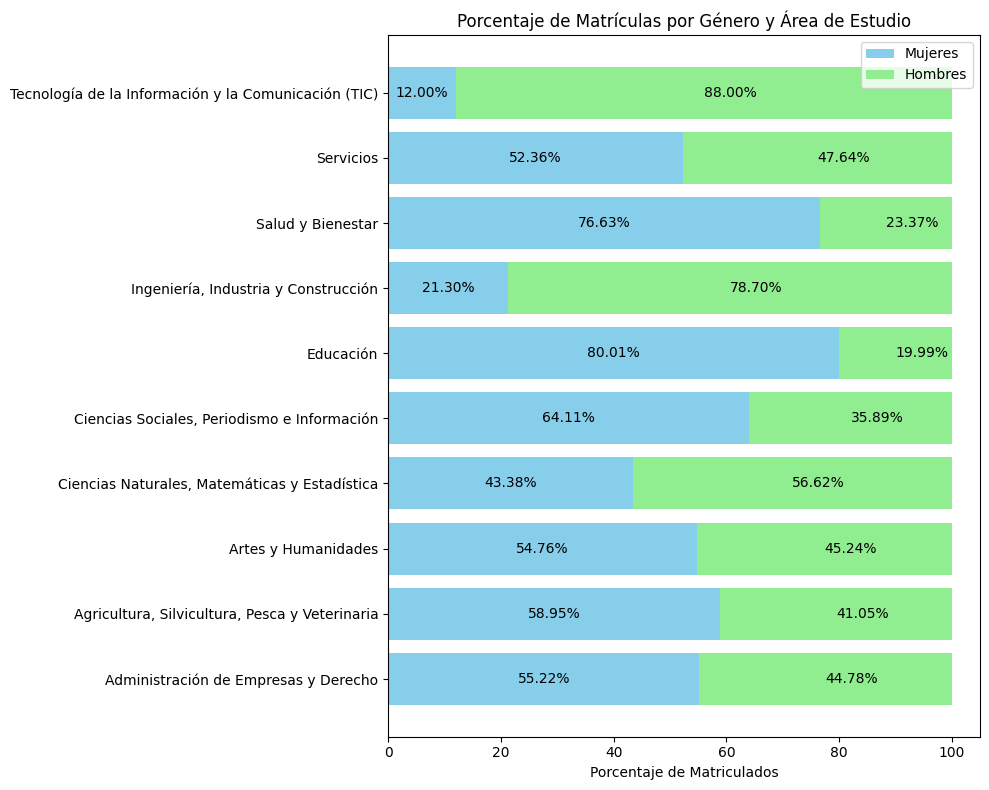

In [15]:
# Nombres de las áreas de estudio
areas_estudio = [
    'Administración de Empresas y Derecho', 
    'Agricultura, Silvicultura, Pesca y Veterinaria', 
    'Artes y Humanidades', 
    'Ciencias Naturales, Matemáticas y Estadística', 
    'Ciencias Sociales, Periodismo e Información', 
    'Educación', 
    'Ingeniería, Industria y Construcción', 
    'Salud y Bienestar', 
    'Servicios', 
    'Tecnología de la Información y la Comunicación (TIC)'
]

# Porcentajes de matrículas por género en cada área
porcentajes_mujeres = [por_matricula_AD_mujeres, por_matricula_ASPV_mujeres, por_matricula_AH_mujeres, por_matricula_CME_mujeres, por_matricula_CPI_mujeres, por_matricula_E_mujeres, por_matricula_IIC_mujeres, por_matricula_SB_mujeres, por_matricula_S_mujeres, por_matricula_TIC_mujeres]
porcentajes_hombres = [100 - pm for pm in porcentajes_mujeres]

y_pos = np.arange(len(areas_estudio))  # Ubicación de las etiquetas

fig, ax = plt.subplots(figsize=(10, 8))

# Crear barras horizontales apiladas para mujeres
rects1 = ax.barh(y_pos, porcentajes_mujeres, color='skyblue', label='Mujeres')

# Crear barras horizontales apiladas para hombres, comenzando donde terminan las de mujeres
rects2 = ax.barh(y_pos, porcentajes_hombres, left=porcentajes_mujeres, color='lightgreen', label='Hombres')

# Añadir título y etiquetas a los ejes
ax.set_yticks(y_pos)
ax.set_yticklabels(areas_estudio)
ax.set_xlabel('Porcentaje de Matriculados')
ax.set_title('Porcentaje de Matrículas por Género y Área de Estudio')
ax.legend()

# Función para añadir etiquetas sobre cada barra
def autolabel(rects, labels, xpos='inside'):
    for rect, label in zip(rects, labels):
        width = rect.get_width()
        if xpos == 'inside':
            # Mujeres
            ax.annotate('{:.2f}%'.format(label),
                        xy=(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2),
                        xytext=(0, 0),  # Sin offset
                        textcoords="offset points",
                        ha='center', va='center',
                        #color='white'  # Texto en color blanco para mejor contraste
                        )
        else:
            # Hombres
            ax.annotate('{:.2f}%'.format(label),
                        xy=(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2),
                        xytext=(0, 0),  # Offset ligero hacia la derecha
                        textcoords="offset points",
                        ha='left', va='center')

# Añadir etiquetas de porcentaje a las barras
autolabel(rects1, porcentajes_mujeres, xpos='inside')
autolabel(rects2, porcentajes_hombres, xpos='outside')

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

In [16]:
# Obtener los primeros 5 resultados de df_matricula_agregada
primeros_cinco_resultados = df_matricula_agregada.head()

# Mostrar los primeros 5 resultados
print(primeros_cinco_resultados)

                              CINE-F 2013 ÁREA     NIVEL     Sexo  \
0                          Artes y Humanidades  Pregrado  Hombres   
1  Ciencias Sociales, Periodismo e Información  Pregrado  Hombres   
2  Ciencias Sociales, Periodismo e Información  Pregrado  Hombres   
3  Ciencias Sociales, Periodismo e Información  Pregrado  Hombres   
5                                    Educación  Pregrado  Hombres   

   Matriculados  
0          22.0  
1          55.0  
2          16.0  
3          61.0  
5           1.0  


<a id="subseccion-5-8"></a>

## 8. **[Distribución del personal académico de las instituciones de educación superior según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-entre-el-personal-academico-de-las-instituciones-de-educacion-superior-respecto-al-total)**

 * **Archivo**: Personal_Academico_SIES_2022.xlsx
 * **Descripción**: En esta sección, se realiza la carga del archivo Excel y extrae las columnas A, C y D para convertirlo en un DataFrame. Mediante el uso de NumPy, se añade una columna adicional llamada "Tipo de institución". Esta nueva columna se categoriza en base a los valores de "Codigo IES". Para lograr una representación detallada de los datos de personal, el script duplica cada fila del DataFrame resultante para separar los datos de hombres y mujeres, asignando a cada uno la cantidad correspondiente de personal y ajustando la categorización de sexo. Las columnas originales de personal por género se eliminan después de este paso para evitar redundancias. El script finaliza combinando los DataFrames de hombres y mujeres en uno solo, mostrando los datos procesados por consola. Cabe destacar que la columna correspondiente al año se excluye en esta fase ya que en la carga de los datos se utiliza ese argumento.

[Volver al índice](#indice) 

In [17]:
# Abrir el archivo xlsx
personal_xlsx = openpyxl.load_workbook('Personal_Academico_SIES_2022.xlsx')

# Seleccionar la hoja 'BD_Académicos_JCE'
hoja = personal_xlsx['BD_Académicos_JCE']

# Inicializar una lista para almacenar los datos
datos = []

# Iterar sobre las filas de la hoja, empezando por la segunda para omitir el encabezado
for row in hoja.iter_rows(min_row=4):
    # Extraer los valores de las columnas A (1), C (3) y D (4)
    fila = [row[0].value, row[2].value, row[3].value]
    datos.append(fila)

# Cerrar el archivo xlsx
personal_xlsx.close()

# Convertir los datos a un DataFrame de pandas
df_modificacion_1 = pd.DataFrame(datos, columns=['Codigo IES', 'Total Mujeres', 'Total Hombres'])

# Eliminar las filas donde todas las columnas especificadas contienen NaN simultáneamente
df_modificacion_1.dropna(how='all', inplace=True)

# Definir las condiciones (Universidades pertenecientes al CRUCH por código IES)
condiciones = [
    df_modificacion_1['Codigo IES'].isin([3, 34, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 895, 896])
]

# Definir las elecciones correspondientes a cada condición
elecciones = [
    'CRUCH'
]

# Crear la nueva columna 'Tipo de institución'
df_modificacion_1['Tipo de institución'] = np.select(condiciones, elecciones, default= 'NO CRUCH')

# Duplicar cada fila del DataFrame, una para Hombres y otra para Mujeres
df_hombres = df_modificacion_1.copy()
df_mujeres = df_modificacion_1.copy()

# Asignar la categoría correspondiente a la nueva columna 'Sexo'
df_hombres['Sexo'] = 'Hombres'
df_mujeres['Sexo'] = 'Mujeres'

# Asignar a cada fila la cantidad de matriculados de cada sexo y eliminar las columnas innecesarias
df_hombres['Personal'] = df_hombres['Total Hombres']
df_mujeres['Personal'] = df_mujeres['Total Mujeres']

# Eliminar las columnas de matriculados por sexo, ya que no son necesarias después de asignar la 'Cantidad'
df_hombres.drop(['Codigo IES', 'Total Mujeres', 'Total Hombres'], axis=1, inplace=True)
df_mujeres.drop(['Codigo IES', 'Total Mujeres', 'Total Hombres'], axis=1, inplace=True)

# Combinar los DataFrames de hombres y mujeres
df_modificacion_2 = pd.concat([df_hombres, df_mujeres], ignore_index=True)

# Agrupar por 'Tipo de institución' y 'Sexo' y sumar la cantidad de personal
df_academicos = df_modificacion_2.groupby(['Tipo de institución', 'Sexo'])['Personal'].sum().reset_index()

# Mostrar el DataFrame para verificación
print(df_academicos)


  Tipo de institución     Sexo      Personal
0               CRUCH  Hombres  12195.413182
1               CRUCH  Mujeres   8137.480682
2            NO CRUCH  Hombres  14359.479545
3            NO CRUCH  Mujeres  13492.100455


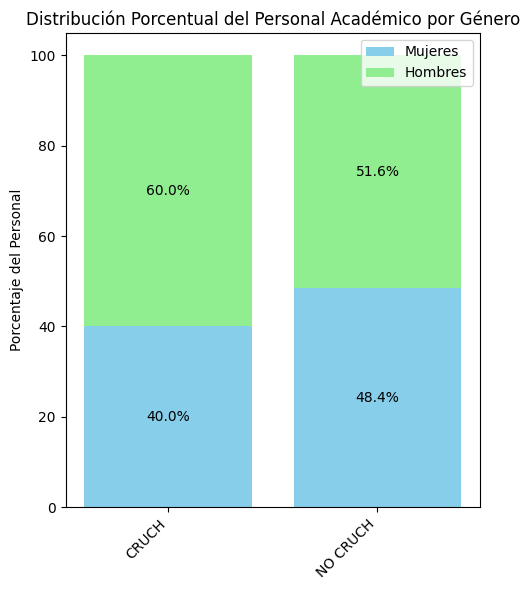

In [18]:
# Calcular el total de personal por tipo de institución
df_total_por_institucion = df_academicos.groupby('Tipo de institución')['Personal'].sum().reset_index()

# Unir el DataFrame original con los totales por tipo de institución
df_academicos = df_academicos.merge(df_total_por_institucion, on='Tipo de institución', suffixes=('', '_Total'))

# Calcular porcentajes
df_academicos['Porcentaje'] = (df_academicos['Personal'] / df_academicos['Personal_Total']) * 100

# Separar los DataFrames por género para facilitar la creación de las barras apiladas
df_mujeres = df_academicos[df_academicos['Sexo'] == 'Mujeres']
df_hombres = df_academicos[df_academicos['Sexo'] == 'Hombres']

# Nombres de las instituciones
instituciones = df_academicos['Tipo de institución'].unique()

# Ubicación de las etiquetas en el eje X
x = np.arange(len(instituciones))

fig, ax = plt.subplots(figsize=(5, 6))

# Crear barras apiladas para mujeres
rects1 = ax.bar(x, df_mujeres['Porcentaje'], label='Mujeres', color='skyblue')

# Crear barras apiladas para hombres, comenzando donde terminan las de mujeres
rects2 = ax.bar(x, df_hombres['Porcentaje'], bottom=df_mujeres['Porcentaje'].values, label='Hombres', color='lightgreen')

# Añadir título y etiquetas a los ejes
ax.set_ylabel('Porcentaje del Personal')
ax.set_title('Distribución Porcentual del Personal Académico por Género')
ax.set_xticks(x)
ax.set_xticklabels(instituciones, rotation=45, ha='right')  # Ajuste para la rotación de las etiquetas
ax.legend()

# Función para añadir etiquetas sobre cada barra
def autolabel(rects, df):
    for rect, percentage in zip(rects, df['Porcentaje']):
        height = rect.get_y() + rect.get_height() / 2  # Colocar la etiqueta en el centro de cada sección
        ax.annotate('{:.1f}%'.format(percentage),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # Sin offset
                    textcoords="offset points",
                    ha='center', va='center')

# Añadir etiquetas de porcentaje a las barras de mujeres
autolabel(rects1, df_mujeres)

# Añadir etiquetas de porcentaje a las barras de hombres, utilizando solo el porcentaje de hombres
autolabel(rects2, df_hombres)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()


<a id="seccion-6"></a>

# **III) Carga**

[Volver al índice](#indice) 

In [19]:
# importamos las librerías respectivas y leemos la credencial de acceso
import psycopg2
import configparser

config = configparser.ConfigParser()
config.read('credencial_login.conf')
database = config['postgresql']['database']
user     = config['postgresql']['user']
password = config['postgresql']['password']
host     = config['postgresql']['host']
port     = config['postgresql']['port']

<a id="subseccion-6-2"></a>

## 2. **[Evolución de matrículas anuales en pregrado y postgrado en universidades en chile.](https://www.observa.minciencia.gob.cl/indicadores/formacion-y-capital-humano/evolucion-matricula-pregrado-magister-y-doctorado-en-universidades-en-chile)**

 * **Tabla BD:** SIES_matricula
 * modificar variable **primeros_cinco_resultados_matricula** a **df_matricula** 
 
[Volver al índice](#indice)  

In [ ]:
def verificarDato(cursor, año):
    query = "SELECT COUNT(*) FROM \"SIES_Matricula\" WHERE \"AÑO\" = %s"
    cursor.execute(query, (año,))
    resultado = cursor.fetchone()
    return resultado[0] > 0

def cargarDatos(connection, primeros_cinco_resultados_matricula):
   with connection.cursor() as cursor:
        if not verificarDato(cursor, '2022'):
            for _, row in primeros_cinco_resultados_matricula.iterrows():
                query = """
                INSERT INTO "SIES_Matricula" ("AÑO", "TOTAL MATRICULADOS", "MATRICULADOS MUJERES POR PROGRAMA", "MATRICULADOS HOMBRES POR PROGRAMA", "CLASIFICACIÓN INSTITUCIÓN NIVEL 1", "CLASIFICACIÓN INSTITUCIÓN NIVEL 2", "CLASIFICACIÓN INSTITUCIÓN NIVEL 3", "REGIÓN", "NOMBRE CARRERA", "ÁREA DEL CONOCIMIENTO", "CINE-F 1997 AREA", "CINE-F 1997 SUBAREA", "ÁREA CARRERA GENÉRICA", "CINE-F 2013 AREA", "CINE-F 2013 SUBAREA", "NIVEL GLOBAL", "CARRERA CLASIFICACIÓN NIVEL 1", "CARRERA CLASIFICACIÓN NIVEL 2", "AUX_NIVEL")
                VALUES ('2022', %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """
                cursor.execute(query, tuple(row))
            print('Datos del indicador ingresado con éxito')
        else:
            print('Ya existe un registro para el año 2022')

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        database=database,
        user=user,
        password=password,
        host=host,
        port=port
    )
    connection.autocommit = True
    print('Conexión iniciada') 
    cargarDatos(connection, primeros_cinco_resultados_matricula)

except psycopg2.DatabaseError as e:
    print(f"Error al conectarse a la base de datos: {e}")
finally:
    if connection:
        connection.close()
        print('Conexión finalizada')

Error al conectarse a la base de datos: connection to server at "localhost" (::1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?



NameError: name 'connection' is not defined

<a id="subseccion-6-5"></a>

## 5. **[Porcentaje de personas matriculadas en educación superior, según sexo respecto al total de personas matriculadas.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-la-educacion-superior-respecto-al-total)**

<a id="subseccion-6-6"></a>

## 6. **[Distribución de matrículas de pregrado, magíster y doctorado según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado)**

<a id="subseccion-6-7"></a>

## 7. **[Distribución de personas matriculadas en pregrado según sexo por campo de educación.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-matriculadas-en-pregrado-magister-y-doctorado-por-area-de-conocimiento)**

 * **Tabla BD:** SIES_Matricula_Agregada
 * modificar variable **primeros_cinco_resultados** a **df_matricula_agregada** 

[Volver al índice](#indice)   

In [ ]:
def verificarDato(cursor, año):
    query = "SELECT COUNT(*) FROM \"SIES_Matricula_Agregada\" WHERE \"Agno\" = %s"
    cursor.execute(query, (año,))
    resultado = cursor.fetchone()
    return resultado[0] > 0

def cargarDatos(connection, primeros_cinco_resultados):
   with connection.cursor() as cursor:
        if not verificarDato(cursor, '2022'):
            for _, row in primeros_cinco_resultados.iterrows():
                query = """
                INSERT INTO "SIES_Matricula_Agregada" ("Agno", "CINE F 2013", "Nivel", "Sexo", "Matriculados")
                VALUES ('2022', %s, %s, %s, %s)
                """
                cursor.execute(query, tuple(row))
            print('Datos del indicador ingresado con éxito')
        else:
            print('Ya existe un registro para el año 2022')

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        database=database,
        user=user,
        password=password,
        host=host,
        port=port
    )
    connection.autocommit = True
    print('Conexión iniciada') 
    cargarDatos(connection, primeros_cinco_resultados)

except psycopg2.DatabaseError as e:
    print(f"Error al conectarse a la base de datos: {e}")
finally:
    if connection:
        connection.close()
        print('Conexión finalizada')

Conexión iniciada
Datos del indicador ingresado con éxito
Conexión finalizada


<a id="subseccion-6-8"></a>

## 8. **[Distribución del personal académico de las instituciones de educación superior según sexo.](https://www.observa.minciencia.gob.cl/genero/formacion-y-capital-humano/porcentaje-de-mujeres-entre-el-personal-academico-de-las-instituciones-de-educacion-superior-respecto-al-total)**

 * **Tabla BD:** SIES_Academicos

[Volver al índice](#indice)    

In [ ]:
def verificarDato(cursor, año):
    query = "SELECT COUNT(*) FROM \"SIES_Academicos\" WHERE \"Año\" = %s"
    cursor.execute(query, (año,))
    resultado = cursor.fetchone()
    return resultado[0] > 0

def cargarDatos(connection, df_academicos):
   with connection.cursor() as cursor:
        if not verificarDato(cursor, '2022'):
            for _, row in df_academicos.iterrows():
                query = """
                INSERT INTO "SIES_Academicos" ("Año", "Tipo de institución", "Sexo", "Personal")
                VALUES ('2022', %s, %s, %s)
                """
                cursor.execute(query, tuple(row))
            print('Datos del indicador ingresado con éxito')
        else:
            print('Ya existe un registro para el año 2022')

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        database=database,
        user=user,
        password=password,
        host=host,
        port=port
    )
    connection.autocommit = True
    print('Conexión iniciada') 
    cargarDatos(connection, df_academicos)

except psycopg2.DatabaseError as e:
    print(f"Error al conectarse a la base de datos: {e}")
finally:
    if connection:
        connection.close()
        print('Conexión finalizada')

Conexión iniciada
Datos del indicador ingresado con éxito
Conexión finalizada
